<a href="https://colab.research.google.com/github/Leos1999/GoldPricePredictor/blob/master/GoldPricePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [59]:
data_URL = "https://raw.githubusercontent.com/Leos1999/GoldPricePredictor/master/goldrate.csv"
data = pd.read_csv(data_URL)
data.head()
data = data.iloc[:-10,1].values.reshape(-1,1)
print(data.shape)
scaler = MinMaxScaler(feature_range = (0, 1))

(597, 1)


In [60]:
def train_test_split_norm(data):
  data_norm = scaler.fit_transform(data)
  size = 0.85
  train_size = int(len(data_norm) * size)
  test_size = len(data_norm) - train_size
  train, test = data_norm[0:train_size, :], data_norm[train_size:len(data_norm), :]
  # print("Number of entries (training set, test set): " + str((len(train), len(test))))
  return train,test

In [61]:
def create_dataset(dataset, window_size):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [62]:
def window_maker(data,window_size):
  train,test = train_test_split_norm(data)
  train_X, train_Y = create_dataset(train, window_size)
  test_X, test_Y = create_dataset(test, window_size)
  print("Original training data shape:")
  print(train_X.shape)
  train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
  test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
  print("New training data shape:")
  print(train_X.shape)
  return train_X,train_Y,test_X,test_Y,train,test

In [63]:
def step_decay(epoch):
  initial_lrate = 0.01
  drop = 0.3
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

def model_bulid(train_X,train_Y,test_X,test_Y,window_size):
  model = Sequential()
  model.add(LSTM(24,input_shape = (1, window_size),return_sequences=True))
  model.add(LSTM(60,input_shape = (1, window_size),return_sequences=True))
  model.add(LSTM(60,input_shape = (1, window_size)))
  model.add(Dense(10))
  model.add(Dense(1))
  model.compile(loss = "mean_squared_error", optimizer = "adam",metrics='mean_absolute_error')

  ckpt_model = 'model_gold.hdf5'
  checkpoint = ModelCheckpoint(ckpt_model,monitor='val_loss',verbose=0,
                               save_best_only=True,mode='min')
  lrate = 0.001
  lrate = LearningRateScheduler(step_decay)
  callbacks_list = [checkpoint,lrate]

  history = model.fit(train_X, train_Y, epochs = 50, batch_size = 1, verbose = 1,callbacks=callbacks_list,validation_data=(test_X,test_Y))
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test') 
  plt.legend()
  plt.show()
  return history,model

In [64]:
def predict_and_score(X, Y):   
    pred = scaler.inverse_transform(model.predict(X))
    orig_data = scaler.inverse_transform([Y])
    print(orig_data.shape)
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

Original training data shape:
(504, 2)
New training data shape:
(504, 1, 2)
Epoch 1/50
504/504 [==============================] - 4s 7ms/step - loss: 0.0116 - mean_absolute_error: 0.0653 - val_loss: 0.0025 - val_mean_absolute_error: 0.0410 - lr: 0.0100
Epoch 2/50
504/504 [==============================] - 2s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0339 - val_loss: 0.0857 - val_mean_absolute_error: 0.2869 - lr: 0.0100
Epoch 3/50
504/504 [==============================] - 2s 5ms/step - loss: 0.0033 - mean_absolute_error: 0.0324 - val_loss: 0.0014 - val_mean_absolute_error: 0.0277 - lr: 0.0100
Epoch 4/50
504/504 [==============================] - 3s 5ms/step - loss: 0.0020 - mean_absolute_error: 0.0294 - val_loss: 0.0475 - val_mean_absolute_error: 0.2148 - lr: 0.0100
Epoch 5/50
504/504 [==============================] - 3s 5ms/step - loss: 0.0030 - mean_absolute_error: 0.0330 - val_loss: 0.0014 - val_mean_absolute_error: 0.0288 - lr: 0.0100
Epoch 6/50
504/504 [===================

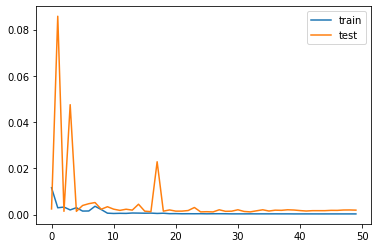

(1, 504)
(1, 87)
Training data score: 31.172944716284416 RMSE
Test data score: 78.40215042916486 RMSE


In [65]:
window = 2
train_X,train_Y,test_X,test_Y,train,test = window_maker(data,window)
history,model = model_bulid(train_X,train_Y,test_X,test_Y,window)
rmse_train, train_predict = predict_and_score(train_X, train_Y)
rmse_test, test_predict = predict_and_score(test_X, test_Y)
print("Training data score:",rmse_train,"RMSE")
print("Test data score:",rmse_test,"RMSE")

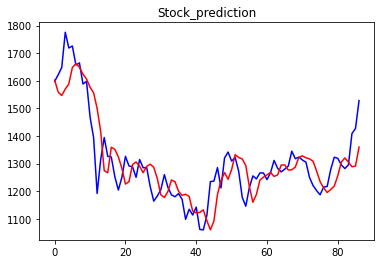

In [66]:
model = load_model("/content/model_gold.hdf5")
pred = model.predict(test_X)
pred = scaler.inverse_transform(pred)
tst = test[window+1:]
plt.plot(scaler.inverse_transform(tst),color='blue')
plt.plot(pred,color='red')
plt.title('Stock_prediction')
plt.show()

##Gold Price Prediction for next 10 periods

(1, 9)


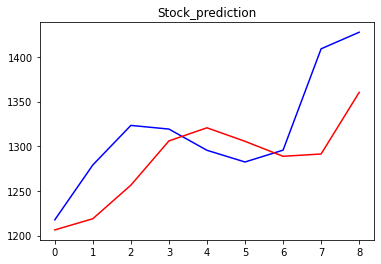

In [67]:
dataset = data[-12:,0].reshape(-1,1)
dataset = scaler.transform(dataset)
data_X, data_Y = [], []
for i in range(len(dataset) - window - 1):
    a = dataset[i:(i + window), 0]
    data_X.append(a)
    data_Y.append(dataset[i + window, 0])
data_X, data_Y = np.array(data_X),np.array(data_Y)
data_X = np.reshape(data_X, (data_X.shape[0], 1, data_X.shape[1]))
rmse_data, data_predict = predict_and_score(data_X, data_Y)
pred = model.predict(data_X)
pred = scaler.inverse_transform(pred)
plt.plot(scaler.inverse_transform(data_Y.reshape(-1,1)),color='blue')
plt.plot(pred,color='red')
plt.title('Stock_prediction')
plt.show()